In [37]:
import pandas as pd 
import numpy as np
import glob
import os
import ast
import time

In [38]:

#모든 Tier의 MatchData 하나로 병합

# 1단계: 파일 찾기
files = glob.glob("TFT_*_MatchData.*")

print("찾은 파일:")
for f in files:
    print(f"  {f}")
print()


# 2단계: 파일 읽어서 합치기
all_data = []  

for file in files:
    df = pd.read_csv(file) 
    
    # 티어 이름 추출 (TFT_Challenger_MatchData.csv → Challenger)
    tier_name = file.split("_")[1]
    df["Tier"] = tier_name
    all_data.append(df)
    
    print(f"{tier_name}: {len(df):,}개")


# 3단계: 하나로 합치기
merged = pd.concat(all_data, ignore_index=True)
print(f"\n합친 결과: {len(merged):,}개")


# 4단계: 중복 제거
# gameID 컬럼이 있으면 중복 제거
if 'gameID' in merged.columns:
    merged = merged.drop_duplicates(subset=['gameID'])
    print(f"중복 제거 후: {len(merged):,}개")
else:
    print("중복 제거 안 함 (gameID 컬럼 없음)")

# 5단계: 저장하기
merged.to_csv("TFT_All_Tier.csv", index=False, encoding='utf-8-sig')
print("\n 완료! → TFT_All_Tier.csv 파일 생성됨")


# 6단계: 결과 확인
print("\n티어별 개수:")
print(merged['Tier'].value_counts())

print("\n데이터 미리보기:")
merged.head()

찾은 파일:
  TFT_Challenger_MatchData.csv
  TFT_Diamond_MatchData.csv
  TFT_GrandMaster_MatchData.csv
  TFT_Master_MatchData.csv
  TFT_Platinum_MatchData.csv

Challenger: 79,999개
Diamond: 80,000개
GrandMaster: 80,000개
Master: 79,999개
Platinum: 80,000개

합친 결과: 399,998개
중복 제거 안 함 (gameID 컬럼 없음)

 완료! → TFT_All_Tier.csv 파일 생성됨

티어별 개수:
Tier
Diamond        80000
Platinum       80000
GrandMaster    80000
Challenger     79999
Master         79999
Name: count, dtype: int64

데이터 미리보기:


,gameId,gameDuration,level,lastRound,Ranked,ingameDuration,combination,champion,Tier
0,KR_4247538593,2142.470703,8,35,1,2134.272217,"{'DarkStar': 2, 'Protector': 4, 'Rebel': 1, 'S...","{'JarvanIV': {'items': [27], 'star': 3}, 'Sona...",Challenger
1,KR_4247538593,2142.470703,9,35,2,2134.272217,"{'Blaster': 2, 'Mercenary': 1, 'Rebel': 6, 'Se...","{'Malphite': {'items': [7], 'star': 2}, 'Yasuo...",Challenger
2,KR_4247538593,2142.470703,8,34,3,2073.459229,"{'Cybernetic': 1, 'DarkStar': 3, 'Demolitionis...","{'KaiSa': {'items': [99, 2, 23], 'star': 2}, '...",Challenger
3,KR_4247538593,2142.470703,8,33,4,1998.146729,"{'Blaster': 1, 'Cybernetic': 1, 'DarkStar': 1,...","{'KaiSa': {'items': [44, 37], 'star': 2}, 'Ann...",Challenger
4,KR_4247538593,2142.470703,9,33,5,1986.443237,"{'Blaster': 2, 'Demolitionist': 2, 'Mercenary'...","{'Ziggs': {'items': [], 'star': 1}, 'Yasuo': {...",Challenger


In [39]:
df = pd.read_csv("TFT_ALL_Tier.csv")

In [40]:

# 결측치 확인
df.isnull().sum()

gameId            0
gameDuration      0
level             0
lastRound         0
Ranked            0
ingameDuration    0
combination       0
champion          0
Tier              0
dtype: int64

In [41]:
print("Raw_data:", len(df), "개")
print()

Raw_data: 399998 개



In [42]:
# 게임당 8명이 아닌 게임 제거

game_counts = df.groupby('gameId').size()
outlier_games = game_counts[game_counts != 8].index

before = len(df)
df = df[~df['gameId'].isin(outlier_games)]
after = len(df)

print(f"8명 아닌 게임 제거: {before - after}개 제거됨 ({len(outlier_games)}개 게임)")

8명 아닌 게임 제거: 318개 제거됨 (21개 게임)


In [43]:
# 레벨 이상치 제거(1~9)
before = len(df)
df = df[(df['level'] >= 1) & (df['level'] <= 9)]
after = len (df)

print(f"레벨 이상치 제거: {before - after}개 제거됨")

레벨 이상치 제거: 0개 제거됨


In [44]:
# 게임 시간 이상치 제거 (10~60분)
outlier_duration = df[(df['gameDuration'] < 600) | (df['gameDuration'] > 3600)]

print(f"게임시간 이상치: {len(outlier_duration)}개")

# 이상치 확인하기
print(df[(df['gameDuration'] < 600) | (df['gameDuration'] > 3600)][['gameId', 'gameDuration']].head())
    
before = len(df)
df = df[(df['gameDuration'] >=600) & (df['gameDuration'] <= 3600)]
after = len(df)

print(f"게임시간 이상치 제거: {before - after}개 제거됨")



게임시간 이상치: 144개
              gameId  gameDuration
65959  KR_4347890020     38.888447
65960  KR_4347890020     38.888447
65961  KR_4347890020     38.888447
65962  KR_4347890020     38.888447
65963  KR_4347890020     38.888447
게임시간 이상치 제거: 144개 제거됨


In [45]:
# combination 빈 값 제거

before = len(df)
df = df[df['combination'].notnull()]
df = df[df['combination'].astype(str).str.len() > 0]
after = len(df)

print(f"comb 빈 값 제거: {before - after}개 제거됨")

comb 빈 값 제거: 0개 제거됨


In [46]:
# champion 빈 값 제거

before = len(df)
df = df[df['champion'].notnull()]
after = len(df)

print(f"champion 빈 값 제거: {before - after}개 제거됨")

champion 빈 값 제거: 0개 제거됨


In [47]:
# 이상치 처리 후, 저장

df.to_csv("TFT_Clean_Data.csv", index=False, encoding='utf-8-sig')
print("저장 완료: TFT_Clean_Data.csv")

저장 완료: TFT_Clean_Data.csv


In [48]:
df1 = pd.read_csv("TFT_Clean_Data.csv")
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399536 entries, 0 to 399535
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   gameId          399536 non-null  object 
 1   gameDuration    399536 non-null  float64
 2   level           399536 non-null  int64  
 3   lastRound       399536 non-null  int64  
 4   Ranked          399536 non-null  int64  
 5   ingameDuration  399536 non-null  float64
 6   combination     399536 non-null  object 
 7   champion        399536 non-null  object 
 8   Tier            399536 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 27.4+ MB


In [49]:
#TFT 메타데이터 매핑

#데이터 불러오기

df_clean = pd.read_csv("TFT_Clean_Data.csv")
df_champion = pd.read_csv("TFT_Champion_CurrentVersion.csv")
df_item = pd.read_csv("TFT_Item_CurrentVersion.csv")

print(f"Clean 데이터: {len(df_clean):,}개")
print(f"챔피언 데이터: {len(df_champion):,}개")
print(f"아이템 데이터: {len(df_item):,}개")
print()

Clean 데이터: 399,536개
챔피언 데이터: 52개
아이템 데이터: 54개



In [50]:
# 챔피언 데이터 확인

print("첫 번째 champion 예시:")
print(df_clean['champion'].iloc[0])
print()
print("데이터 타입:", type(df_clean['champion'].iloc[0]))
print()


첫 번째 champion 예시:
{'JarvanIV': {'items': [27], 'star': 3}, 'Sona': {'items': [46], 'star': 3}, 'Rakan': {'items': [37, 69], 'star': 3}, 'XinZhao': {'items': [69, 25, 25], 'star': 3}, 'Neeko': {'items': [], 'star': 2}, 'Karma': {'items': [], 'star': 2}, 'Soraka': {'items': [], 'star': 2}, 'Lulu': {'items': [59], 'star': 1}}

데이터 타입: <class 'str'>



In [56]:
#champion을 딕셔너리로 변환 (팀장님..의견 parse)
def parse_champion(x):
    if pd.isnull(x):
        return{}
    if isinstance(x, dict):
        return x
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return{}
    return{}

df_clean['champion_dict'] = df_clean['champion'].apply(parse_champion)

df_clean['champion_list'] = df_clean['champion_dict'].apply(
    lambda x: list(x.keys()) if isinstance(x, dict) else[]
)

print("변환된 champion_list:")
print(df_clean['champion_list'].head(10))


변환된 champion_list:
0    [JarvanIV, Sona, Rakan, XinZhao, Neeko, Karma,...
1    [Malphite, Yasuo, Sona, MasterYi, Jinx, Soraka...
2    [KaiSa, Annie, Shaco, Rumble, Karma, Lux, Fizz...
3    [KaiSa, Annie, Shaco, Rumble, Fizz, MissFortun...
4    [Ziggs, Yasuo, Sona, MasterYi, Jinx, MissFortu...
5    [Ziggs, Malphite, Yasuo, Sona, MasterYi, Jinx,...
6    [Malphite, Graves, Blitzcrank, Lucian, Ezreal,...
7    [Malphite, Blitzcrank, Lucian, Ezreal, Vi, Jin...
8    [Malphite, Yasuo, Sona, MasterYi, Jinx, MissFo...
9    [Malphite, Blitzcrank, Lucian, Ezreal, Vi, Jin...
Name: champion_list, dtype: object


In [57]:

df_exploded = df_clean.explode('champion_list')
df_exploded = df_exploded.rename(columns={'champion_list': 'champion_name'})

df_exploded = df_exploded[df_exploded['champion_name'].notnull()]
df_exploded = df_exploded[df_exploded['champion_name'] !='']

print(f"explode 후: {len(df_exploded):,}개")

explode 후: 3,154,257개


In [59]:
# 매핑 (merge)

df_exploded['champion_name_lower'] = df_exploded['champion_name'].str.lower()
df_champion['name_lower'] = df_champion['name'].str.lower()


df_mapped = df_exploded.merge(
    df_champion,
    left_on='champion_name_lower',
    right_on='name_lower',
    how='left'
)

print(f"매핑 완료: {len(df_mapped):,}개")

# 매핑 안된거 확인
unmapped_count = df_mapped['cost'].isna().sum()
print(f"매핑 안 된 행: {unmapped_count:,}개")

if unmapped_count > 0:
    print("\n 매핑 안 된 챔피언:")
    unmapped_champs = df_mapped[df_mapped['cost'].isna()]['champion_name'].value_counts()
    print(unmapped_champs.head(10))
else:
    print(" 모든 챔피언 매핑 완료!")

print()


매핑 완료: 3,154,257개
매핑 안 된 행: 18,764개

 매핑 안 된 챔피언:
champion_name
Kindred     845
Volibear    676
DrMundo     610
Twitch      575
Sion        574
Yorick      569
Nautilus    548
Veigar      545
Ornn        530
Brand       515
Name: count, dtype: int64



In [ ]:
# 주요 컬럼 확인

key_columns = ['gameId', 'Ranked', 'champion_name', 'cost', 'health', 'attack', 'dps', 'origin', 'class']
print(df_mapped[key_columns].head(10))
print()

          gameId  Ranked champion_name  cost  health  attack   dps  \
0  KR_4247538593       1      JarvanIV   1.0   650.0    50.0  30.0   
1  KR_4247538593       1          Sona   2.0   550.0    40.0  26.0   
2  KR_4247538593       1         Rakan   2.0   600.0    45.0  32.0   
3  KR_4247538593       1       XinZhao   2.0   650.0    60.0  42.0   
4  KR_4247538593       1         Neeko   3.0   800.0    50.0  33.0   
5  KR_4247538593       1         Karma   3.0   600.0    50.0  33.0   
6  KR_4247538593       1        Soraka   4.0   700.0    45.0  34.0   
7  KR_4247538593       1          Lulu   5.0   800.0    45.0  36.0   
8  KR_4247538593       2      Malphite   1.0   700.0    70.0  35.0   
9  KR_4247538593       2         Yasuo   2.0   600.0    50.0  38.0   

          origin            class  
0      Dark Star    ['Protector']  
1          Rebel       ['Mystic']  
2      Celestial    ['Protector']  
3      Celestial    ['Protector']  
4  Star Guardian    ['Protector']  
5      Dark S

In [61]:
# 매핑 데이터 저장

df_mapped.to_csv("TFT_Mapped_data.csv", index=False, encoding='utf=-8-sig')
print("저장 완료; TFT_Mapped_Data.csa")

저장 완료; TFT_Mapped_Data.csa


In [62]:
# 매핑 되지 않은 챔피언 상세 분석

df_mapped = pd.read_csv("TFT_Mapped_data.csv")
df_champion = pd.read_csv("TFT_Champion_CurrentVersion.csv")


unmapped = df_mapped[df_mapped['cost'].isnull()]

print(f"매핑 안 된 행:{len(unmapped):,}개")

# 매핑 안 된 챔피언 찾기
unmapped_champions = unmapped['champion_name'].value_counts()
print(unmapped_champions)

매핑 안 된 행:18,764개
champion_name
Kindred           845
Volibear          676
DrMundo           610
Twitch            575
Sion              574
Yorick            569
Nautilus          548
Veigar            545
Ornn              530
Brand             515
Vladimir          499
Taric             499
Renekton          497
Braum             489
Malzahar          479
Aatrox            470
Zed               457
Varus             456
LeBlanc           453
Azir              448
Amumu             446
Sivir             434
Jax               420
Senna             413
Singed            411
Nasus             411
Olaf              408
RekSai            393
Janna             392
KogMaw            389
Nami              389
Taliyah           385
Vayne             384
Nocturne          374
Skarner           365
Zyra              347
Diana             305
Warwick           273
Maokai            193
Ivern             178
QiyanaInferno      92
QiyanaWind         92
QiyanaOcean        91
QiyanaWoodland     69
L

In [64]:
# 메타 데이터와 비교 분석
meta_champions = df_champion['name'].sort_values().tolist()   #tolist()는 리스트를 리스트로 변환하는 메서드

print(f"메타 데이터 챔피언 수: {len(meta_champions)}개")

메타 데이터 챔피언 수: 52개


In [68]:
unmapped_list = unmapped_champions.index.tolist()

for match_name in unmapped_list:
    print(f"'{match_name}'와 유사")

    match_lower = match_name.lower()

    exact_match = [m for m in meta_champions if m.lower() == match_lower]
    if exact_match:
        print(f"완전 일치: {exact_match[0]}")
        continue

    partial_match = [m for m in meta_champions if match_lower in m.lower() or m.lower() in match_lower]
    if partial_match:
        print(f"부분 일치: {partial_match}")
    else:
        print(f"유사 이름 없음")

'Kindred'와 유사
유사 이름 없음
'Volibear'와 유사
유사 이름 없음
'DrMundo'와 유사
유사 이름 없음
'Twitch'와 유사
유사 이름 없음
'Sion'와 유사
유사 이름 없음
'Yorick'와 유사
유사 이름 없음
'Nautilus'와 유사
유사 이름 없음
'Veigar'와 유사
유사 이름 없음
'Ornn'와 유사
유사 이름 없음
'Brand'와 유사
유사 이름 없음
'Vladimir'와 유사
유사 이름 없음
'Taric'와 유사
유사 이름 없음
'Renekton'와 유사
유사 이름 없음
'Braum'와 유사
유사 이름 없음
'Malzahar'와 유사
유사 이름 없음
'Aatrox'와 유사
유사 이름 없음
'Zed'와 유사
유사 이름 없음
'Varus'와 유사
유사 이름 없음
'LeBlanc'와 유사
유사 이름 없음
'Azir'와 유사
유사 이름 없음
'Amumu'와 유사
유사 이름 없음
'Sivir'와 유사
부분 일치: ['vi']
'Jax'와 유사
유사 이름 없음
'Senna'와 유사
유사 이름 없음
'Singed'와 유사
유사 이름 없음
'Nasus'와 유사
유사 이름 없음
'Olaf'와 유사
유사 이름 없음
'RekSai'와 유사
유사 이름 없음
'Janna'와 유사
유사 이름 없음
'KogMaw'와 유사
유사 이름 없음
'Nami'와 유사
유사 이름 없음
'Taliyah'와 유사
유사 이름 없음
'Vayne'와 유사
유사 이름 없음
'Nocturne'와 유사
유사 이름 없음
'Skarner'와 유사
유사 이름 없음
'Zyra'와 유사
유사 이름 없음
'Diana'와 유사
유사 이름 없음
'Warwick'와 유사
유사 이름 없음
'Maokai'와 유사
유사 이름 없음
'Ivern'와 유사
유사 이름 없음
'QiyanaInferno'와 유사
유사 이름 없음
'QiyanaWind'와 유사
유사 이름 없음
'QiyanaOcean'와 유사
유사 이름 없음
'QiyanaWoodland'와 유사
유사 이름 없음
'LuxElectric'와 

In [25]:
# TFT 기초 분석 및 시각화

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns




In [11]:
# 데이터 불러오기 및 데이터 확인
df = pd.read_csv("TFT_Mapped_Data.csv")

print(f"전체 데이터: {len(df):,}개")
print(f"전체 게임 수: {df['gameId'].nunique():,}개")

전체 데이터: 3,154,257개
전체 게임 수: 49,942개


In [12]:
# 챔피언 사용 빈도(Top 10)

champion_usage = df['champion_name'].value_counts()
print(champion_usage.head(10))

champion_name
Vi             123505
Blitzcrank     119991
Kassadin       108603
Ezreal         106263
MissFortune    105337
WuKong         101769
Malphite        99352
ChoGath         94823
Shen            91287
Kayle           91078
Name: count, dtype: int64


In [13]:
#챔피언별 평균 순위

champion_avg_rank = df.groupby('champion_name')['Ranked'].mean().sort_values()
print(champion_avg_rank.head(10))

champion_name
LuxWoodland    2.571429
LuxShadow      2.679245
LuxElectric    2.907407
LuxOcean       3.081633
LuxCrystal     3.096154
LuxWind        3.150000
LuxMetal       3.156250
LuxLight       3.178571
LuxGlacial     3.322581
Nami           3.347044
Name: Ranked, dtype: float64


In [19]:
# 사용 빈도(Top 10)- 챔피언 평균 순위

top10_champions = champion_usage.head(10).index.tolist()

top10_stats = df[df['champion_name'].isin(top10_champions)].groupby('champion_name').agg({
    'Ranked': 'mean',
    'champion_name': 'count'
}).rename(columns={'champion_name': 'count'}).sort_values('count', ascending=False)

top10_stats.columns = ['평균 순위', '사용 횟수']
top10_stats['평균 순위'] = top10_stats['평균 순위'].round(2)
print(top10_stats)


               평균 순위   사용 횟수
champion_name               
Vi              4.32  123505
Blitzcrank      4.41  119991
Kassadin        4.38  108603
Ezreal          4.38  106263
MissFortune     3.87  105337
WuKong          4.41  101769
Malphite        4.37   99352
ChoGath         4.25   94823
Shen            4.53   91287
Kayle           4.27   91078


C:\Users\gostj\AppData\Roaming\Python\Python314\site-packages\IPython\core\events.py:82: UserWarning: Glyph 52308 (\N{HANGUL SYLLABLE CAEM}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\gostj\AppData\Roaming\Python\Python314\site-packages\IPython\core\events.py:82: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\gostj\AppData\Roaming\Python\Python314\site-packages\IPython\core\events.py:82: UserWarning: Glyph 50616 (\N{HANGUL SYLLABLE EON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\gostj\AppData\Roaming\Python\Python314\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\gostj\AppData\Roaming\Python\Python314\site-packages\IPython\core\events.py:82: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\g

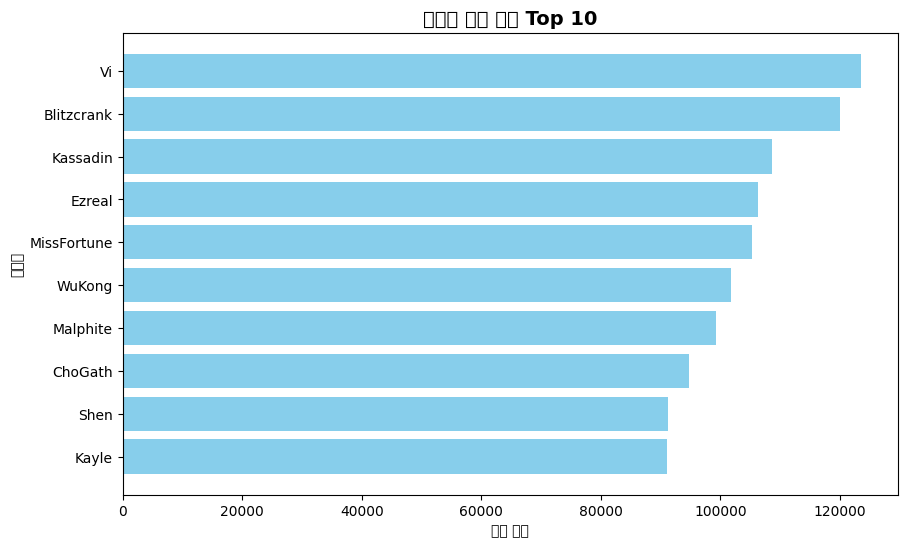

In [39]:
# 시각화 - 챔피언 사용 빈도(Top 10)

plt.figure(figsize=(10, 6))

top10 = champion_usage.head(10)

plt.barh(range(len(top10)), top10.values, color='skyblue')
plt.yticks(range(len(top10)), top10.index)
plt.xlabel('사용 횟수')
plt.ylabel('챔피언')
plt.title('챔피언 사용 빈도 Top 10', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
